In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Veriyi yükle
df = pd.read_csv("C:/Users/Mutlu/Downloads/K_class_sales_clean.csv")

# Veri setinin ilk birkaç satırını incele
print(df.head())

# Veri setindeki eksik verileri kontrol et
print("\nEksik Veriler:")
print(df.isnull().sum())

# Verinin temel istatistiksel özeti
print("\nVerinin Temel İstatistiksel Özeti:")
print(df.describe())


  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy     249.8            OUT049   
1            Soft Drinks      48.3            OUT018   
2                   Meat     141.6            OUT049   
3  Fruits and Vegetables     182.1            OUT010   
4              Household      53.9            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 2   
1                       2009      Medium               Tier 2   
2                       1999      Medium               Tier

In [2]:
# Kategorik değişkenleri sayısala çevir
le = LabelEncoder()  # LabelEncoder nesnesini oluştur
categorical_cols = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
                    'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
# Kategorik sütunları sayısal verilere dönüştür
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Bağımsız ve bağımlı değişkenleri ayır
X = df.drop(columns=['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']

# Veriyi eğitim ve test setlerine böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model listesi
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# Modelleri eğit ve değerlendir
results = {}
for name, model in models.items():  # Her bir model için döngü
    model.fit(X_train, y_train)  # Modeli eğitim verisi ile eğit
    y_pred = model.predict(X_test)  # Test verisi ile tahmin yap
    mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error hesapla
    rmse = np.sqrt(mse)  # Root Mean Squared Error (RMSE) hesapla
    r2 = r2_score(y_test, y_pred)  # R-kare (R²) skorunu hesapla
    results[name] = {'MSE': mse, 'RMSE': rmse, 'R²': r2}  # Sonuçları bir sözlükte topla


# Sonuçları göster
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='RMSE'))


                            MSE         RMSE        R²
Gradient Boosting  1.067890e+06  1033.387476  0.607100
Random Forest      1.152738e+06  1073.656463  0.575883
XGBoost            1.257383e+06  1121.330863  0.537382
Linear Regression  1.277034e+06  1130.059396  0.530151
Decision Tree      2.247645e+06  1499.214947  0.173043


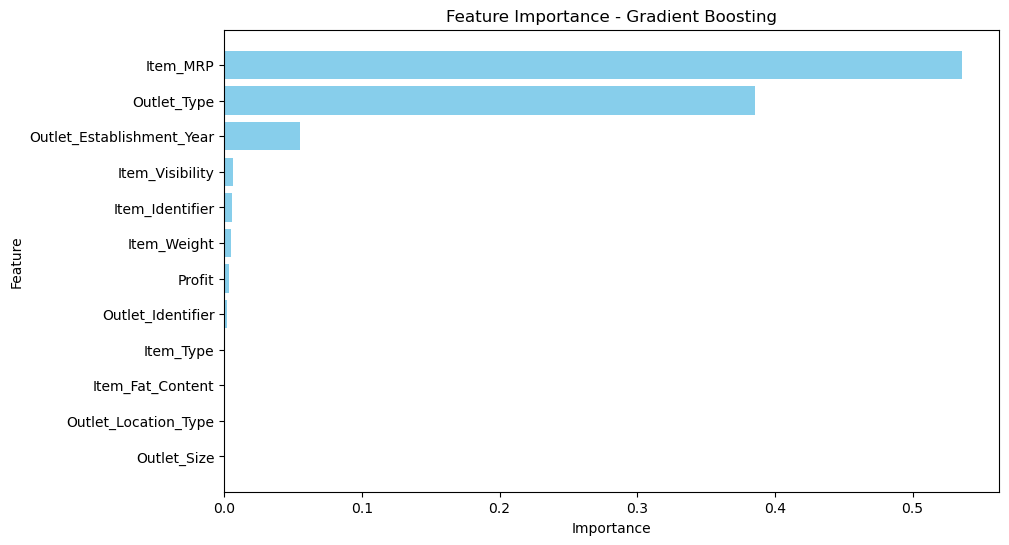

In [3]:
feature_importances = {}  # Özellik önem sıralamalarını saklayacak boş bir sözlük oluştur

for name, model in models.items():  # Her model için döngü
    model.fit(X_train, y_train)  # Modeli eğitim verisi ile eğit
    y_pred = model.predict(X_test)  # Test verisi ile tahmin yap
    mse = mean_squared_error(y_test, y_pred)  # MSE hesapla
    rmse = np.sqrt(mse)  # RMSE hesapla
    r2 = r2_score(y_test, y_pred)  # R² hesapla
    results[name] = {'MSE': mse, 'RMSE': rmse, 'R²': r2}  # Sonuçları sakla
    
    # Özellik önem sırası sadece ağaç tabanlı modeller için alınır
    if hasattr(model, 'feature_importances_'):  # Eğer model özellik önem sırası sunuyorsa
        feature_importances[name] = model.feature_importances_  # Özellik önem sırasını al

# Gradient Boosting için özellik önem sırası
gb_feature_importance = feature_importances.get("Gradient Boosting")  # Gradient Boosting modelinin özellik önem sırasını al
if gb_feature_importance is not None:  # Eğer özellikler mevcutsa
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': gb_feature_importance})  # Özellikleri ve önem sırasını DataFrame'e dönüştür
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)  # Önem sırasına göre sırala
    
    # Görselleştirme
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')  # Bar grafiği ile görselleştir
    plt.xlabel("Importance")  # X eksenine etiket
    plt.ylabel("Feature")  # Y eksenine etiket
    plt.title("Feature Importance - Gradient Boosting")  # Başlık
    plt.gca().invert_yaxis()  # Y eksenini ters çevir, en önemli özellikler üstte görünsün
    plt.show()  # Grafiği göster


In [4]:
# Gradient Boosting hiperparametre optimizasyonu
param_grid = {
    'n_estimators': [100, 200, 300],  # Farklı ağaç sayıları
    'learning_rate': [0.01, 0.05, 0.1],  # Farklı öğrenme hızları
    'max_depth': [3, 5, 7]  # Farklı derinlik değerleri
}

gb_reg = GradientBoostingRegressor(random_state=42)  # GradientBoostingRegressor modelini oluştur
grid_search = GridSearchCV(gb_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)  # GridSearchCV ile parametreleri ara
grid_search.fit(X_train, y_train)  # Eğitim verisi ile en iyi parametreleri bul

# En iyi parametreler ve model sonucu
best_gb = grid_search.best_estimator_  # En iyi modeli seç
y_pred = best_gb.predict(X_test)  # Test verisi ile tahmin yap
mse = mean_squared_error(y_test, y_pred)  # MSE hesapla
rmse = np.sqrt(mse)  # RMSE hesapla
r2 = r2_score(y_test, y_pred)  # R² hesapla

print("Best Parameters:", grid_search.best_params_)  # En iyi parametreleri yazdır
print("Optimized Gradient Boosting Performance:")
print(f"MSE: {mse}")  # MSE'yi yazdır
print(f"RMSE: {rmse}")  # RMSE'yi yazdır
print(f"R²: {r2}")  # R²'yi yazdır


Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Optimized Gradient Boosting Performance:
MSE: 1057463.6863231026
RMSE: 1028.3305335946718
R²: 0.6109362279918655


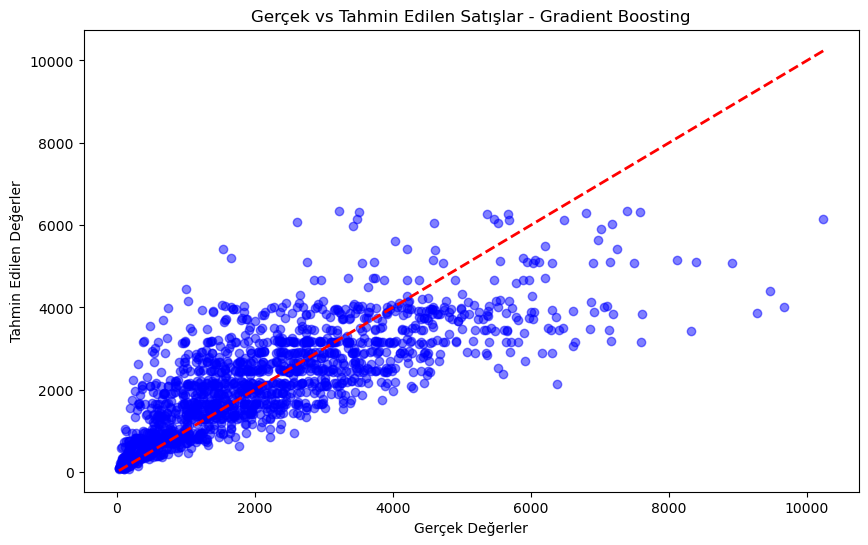

In [5]:
# Tahminleri görselleştir
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue")  # Gerçek değerler ve tahmin edilen değerler
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)  # Gerçek değerler ile tahmin edilen değerler arasındaki ilişkiyi gösteren çizgi
plt.xlabel("Gerçek Değerler")  # X ekseni etiket
plt.ylabel("Tahmin Edilen Değerler")  # Y ekseni etiket
plt.title("Gerçek vs Tahmin Edilen Satışlar - Gradient Boosting")  # Başlık
plt.show()  # Grafiği göster


In [6]:
# Örnek: Model eğitimleri
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Modeli eğit
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)


DecisionTreeRegressor(random_state=42)

In [7]:
# Gradient Boosting tahminlerini al
y_pred_gb = gb_model.predict(X_test)

# Random Forest tahminlerini al
y_pred_rf = rf_model.predict(X_test)

# XGBoost tahminlerini al
y_pred_xgb = xgb_model.predict(X_test)

# Linear Regression tahminlerini al
y_pred_lr = lr_model.predict(X_test)

# Decision Tree tahminlerini al
y_pred_dt = dt_model.predict(X_test)


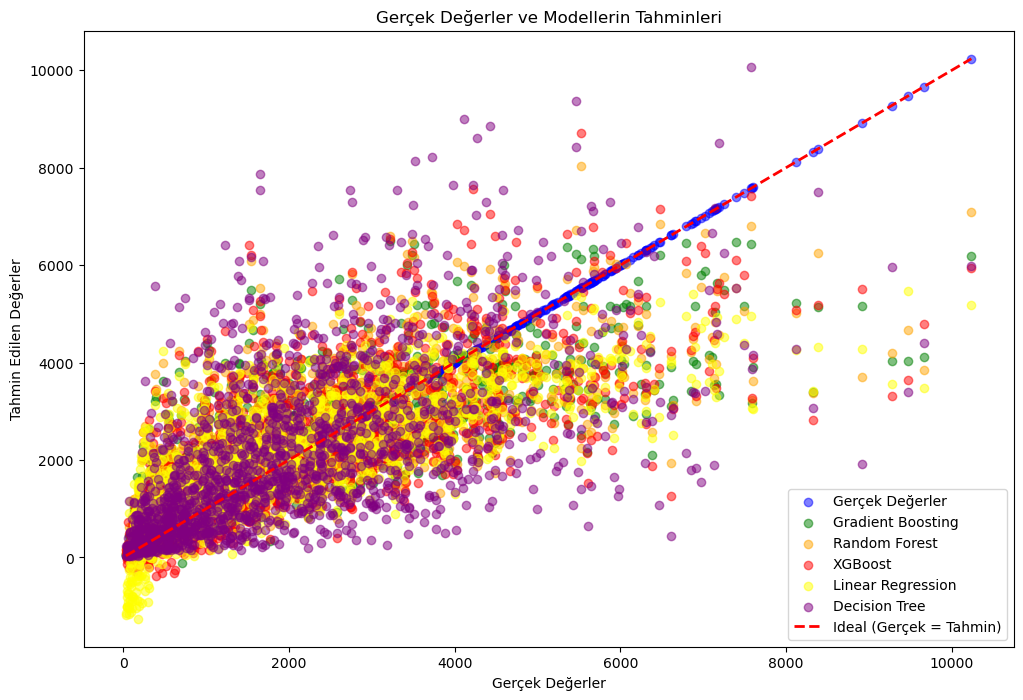

In [8]:
# Grafik oluşturma
plt.figure(figsize=(12, 8))

# Gerçek değerler
plt.scatter(y_test, y_test, alpha=0.5, color="blue", label="Gerçek Değerler")  # Gerçek değerler için mavi noktalar

# Model tahminleri
plt.scatter(y_test, y_pred_gb, alpha=0.5, color="green", label="Gradient Boosting")  # Gradient Boosting tahminleri için yeşil noktalar
plt.scatter(y_test, y_pred_rf, alpha=0.5, color="orange", label="Random Forest")  # Random Forest tahminleri için turuncu noktalar
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color="red", label="XGBoost")  # XGBoost tahminleri için kırmızı noktalar
plt.scatter(y_test, y_pred_lr, alpha=0.5, color="yellow", label="Linear Regression")  # Linear Regression tahminleri için sarı noktalar
plt.scatter(y_test, y_pred_dt, alpha=0.5, color="purple", label="Decision Tree")  # Decision Tree tahminleri için mor noktalar

# Ideal çizgi
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label="Ideal (Gerçek = Tahmin)")  # Gerçek = Tahmin çizgisi

plt.xlabel("Gerçek Değerler")  # X ekseni etiket
plt.ylabel("Tahmin Edilen Değerler")  # Y ekseni etiket
plt.title("Gerçek Değerler ve Modellerin Tahminleri")  # Başlık
plt.legend()  # Legend (açıklama) ekle
plt.show()  # Grafiği göster
